# sRGB vs Linear Blur Demo

This minimal notebook generates simple colored patches and compares Gaussian blur applied in 8-bit sRGB (naive) vs converted-to-linear float (correct) and back.

Run the code cells to produce side-by-side visual comparisons. Requires `Pillow`, `numpy`, and `matplotlib` (install with `pip install pillow numpy matplotlib`).

In [1]:
from PIL import Image, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
import math

# sRGB <-> linear helpers
def srgb_to_linear_f(c):
    # c in 0..1
    if c <= 0.04045:
        return c / 12.92
    return ((c + 0.055) / 1.055) ** 2.4

def linear_to_srgb_f(l):
    if l <= 0.0031308:
        return l * 12.92
    return 1.055 * (l ** (1.0 / 2.4)) - 0.055

def separable_gaussian_kernel(sigma):
    rad = max(1, int(math.ceil(3*sigma)))
    xs = np.arange(-rad, rad+1, dtype=np.float32)
    k = np.exp(-0.5 * (xs / sigma)**2)
    k /= k.sum()
    return k

def separable_blur_float(img_f, sigma):
    # img_f: HxWxC float32 in linear space (0..1)
    if sigma <= 0.3:
        return img_f
    k = separable_gaussian_kernel(sigma)
    H,W,C = img_f.shape
    tmp = np.zeros_like(img_f)
    # convolve rows
    for c in range(C):
        for r in range(H):
            tmp[r,:,c] = np.convolve(img_f[r,:,c], k, mode='same')
    out = np.zeros_like(tmp)
    # convolve columns
    for c in range(C):
        for col in range(W):
            out[:,col,c] = np.convolve(tmp[:,col,c], k, mode='same')
    return out

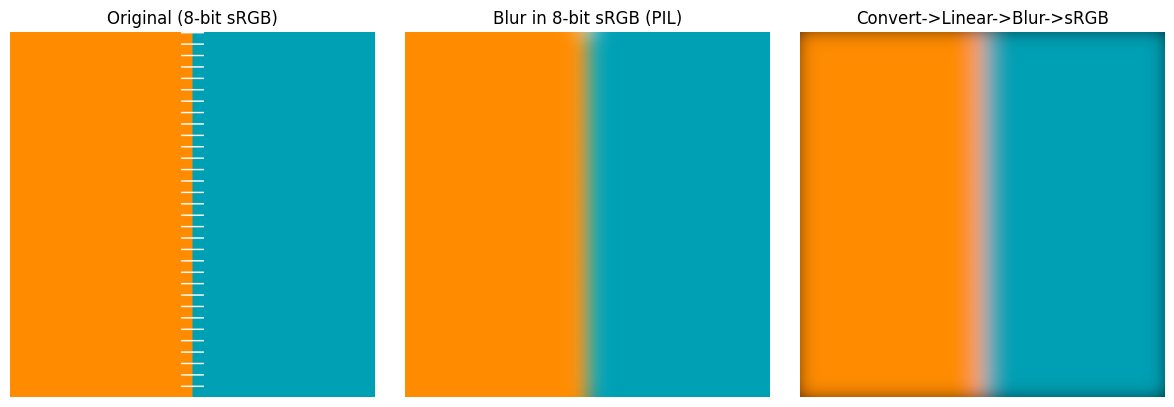

In [2]:
# Build a simple test image: two color patches with a thin checker detail to reveal aliasing
W = 256
H = 256
img = np.zeros((H,W,3), dtype=np.uint8)
# left: orange, right: teal
img[:, :W//2] = [255, 140, 0]  # orange
img[:, W//2:] = [0, 160, 180]  # teal
# add a thin high-frequency horizontal stripe to show aliasing
for y in range(0, H, 8):
    img[y:y+1, W//2-8:W//2+8] = [255,255,255]

# Convert to PIL image
pil = Image.fromarray(img)
# Naive sRGB blur using Pillow (operates on 8-bit RGB)
radius = 6  # choose moderate blur radius
pil_blur_srgb = pil.filter(ImageFilter.GaussianBlur(radius=radius))

# Linear-float blur: convert to linear floats, blur, then convert back
img_f = img.astype(np.float32) / 255.0
# linearize
lin = np.empty_like(img_f)
for c in range(3):
    lin[:,:,c] = np.vectorize(srgb_to_linear_f)(img_f[:,:,c])
# blur in linear space (sigma ~ radius here)
lin_blurred = separable_blur_float(lin, sigma=radius)
# convert back to sRGB
rec = np.empty_like(lin_blurred)
for c in range(3):
    rec[:,:,c] = np.vectorize(linear_to_srgb_f)(lin_blurred[:,:,c])
img_blur_linear = (np.clip(rec, 0.0, 1.0) * 255.0).astype(np.uint8)

# Display side-by-side
fig, axs = plt.subplots(1,3, figsize=(12,4))
axs[0].imshow(img); axs[0].set_title('Original (8-bit sRGB)'); axs[0].axis('off')
axs[1].imshow(pil_blur_srgb); axs[1].set_title('Blur in 8-bit sRGB (PIL)'); axs[1].axis('off')
axs[2].imshow(img_blur_linear); axs[2].set_title('Convert->Linear->Blur->sRGB'); axs[2].axis('off')
plt.tight_layout(); plt.show()